In [18]:
import numpy as np
import matplotlib.pyplot as plt

In [96]:
def plot_image(im, h=5, **kwargs):
    '''
    Helper function to plot an image.
    im: np.array
    '''
    x, y = im.shape[:2]
    w = (y/x)*h
    plt.figure(figsize=(w,h))
    plt.imshow(im, interpolation="none", **kwargs)

In [216]:
im = np.random.randint(low=0, high=255, size=(6000, 6000, 3))
print(im)

[[[ 62 209  71]
  [ 45  24 107]
  [200 205 123]
  ...
  [ 73 139  84]
  [ 23 126  33]
  [212 229  99]]

 [[129 178 238]
  [246   6  59]
  [ 63   5  48]
  ...
  [ 60  22 238]
  [ 90 204  24]
  [ 91  72  20]]

 [[193   7 193]
  [ 89 148 141]
  [102  69 128]
  ...
  [ 60  17  97]
  [  2 186 201]
  [213 159  90]]

 ...

 [[ 68  32 116]
  [ 48 111  37]
  [211 197 156]
  ...
  [ 52  42 129]
  [207  81  44]
  [127 228 195]]

 [[164 253  63]
  [150 166  35]
  [108 142  84]
  ...
  [ 66  23  51]
  [135  38 234]
  [ 40 195 168]]

 [[150 225 203]
  [138  78 223]
  [115 194  46]
  ...
  [154 246 182]
  [159 170 251]
  [161 145  60]]]


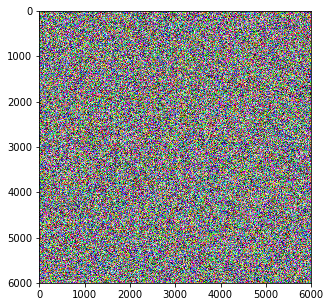

In [217]:
plot_image(im)

In [218]:
mask = np.array([ 
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                ])
res = np.sum(im[0:6, 0:6, :]*mask[:,:,np.newaxis], axis=(0,1))
print(res)

[4525 3770 4300]


In [296]:
def apply_mask_once(im, ma, i, j):
    dx, dy = ma.shape
    start_i, end_i = i*dx, (i+1)*dx
    start_j, end_j = j*dy, (j+1)*dy
    indices = (slice(start_i, end_i), slice(start_j, end_j), slice(None, None))
    pixel = np.sum(im[indices]*ma[:, :, np.newaxis], axis=(0, 1))
    return pixel / (ma.size*255)

In [297]:
apply_mask_once(im, mask, 1, 1)

array([0.61263617, 0.55163399, 0.31154684])

11.8 s ± 99.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


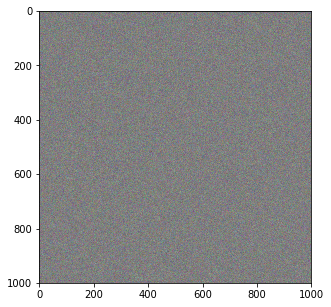

In [304]:
# 6x6
mask = np.ones(shape=(6, 6))
%timeit im_comp = np.array([[apply_mask_once(im, mask, i, j) for i in range(0, 1000)] for j in range(0, 1000)])
plot_image(im_comp)

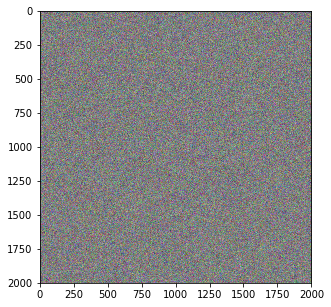

In [230]:
# 3x3
mask = np.ones(shape=(3, 3))
im_comp = np.array([[apply_mask_once(im, mask, i, j) for i in range(0, 2000)] for j in range(0, 2000)])
plot_image(im_comp)

In [231]:
# Timing 
%timeit np.array([[apply_mask_once(im, mask, i, j) for i in range(0, 2000)] for j in range(0, 2000)])

47.1 s ± 6.38 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [400]:
def method1(image, mask):
    
    # Size of the new image
    dx, dy = mask.shape
    Nx = int(image.shape[0]/dx)
    Ny = int(image.shape[1]/dy)
    
    def reduced_pixel(i, j):
        start_i, end_i = i*dx, (i+1)*dx
        start_j, end_j = j*dy, (j+1)*dy
        indices = (slice(start_i, end_i), slice(start_j, end_j), slice(None, None))
        pixel = np.sum(image[indices]*mask[:, :, np.newaxis], axis=(0, 1))
        return pixel / (mask.size*255)
    
    # Result
    res = np.zeros((Nx, Ny, 3))
    for i in range(0, Nx):
        for j in range(0, Ny):
            res[i, j] = reduced_pixel(i, j)
    
    return res

res1 = method2(image, mask)

## Trying with pseudo vectorized approach

Create a mask with the following dimension: `(Nnew, Nold, Nold)`, so one mask per new pixel with a size of the image

In [401]:
def method2(image, mask):

    # Container for the tranformed mask
    Nx = int(image.shape[0]/mask.shape[0])
    Ny = int(image.shape[1]/mask.shape[1])
    trans_mask = np.zeros((Nx, Ny, *image.shape))

    # Filling the transformed mask
    dx, dy = mask.shape
    for i in np.arange(Nx):
        for j in np.arange(Ny):
            start_i, end_i = i*dx, (i+1)*dx
            start_j, end_j = j*dy, (j+1)*dy
            trans_mask[i, j, start_i:end_i, start_j:end_j, :] = mask[:,:, np.newaxis]
            
    # Perform the computation
    convolution = np.sum(image[np.newaxis, ...]*trans_mask, axis=(2, 3))
    image_res = convolution/(mask.size*255)
    
    return image_res

In [402]:
res2 = method2(image, mask)

## Using `convolve2d`

In [484]:
def method3(image, mask):
    from scipy import signal
    
    # Performing 2D convolution
    args = {'in2': mask, 'mode': 'same', 'boundary': 'fill', 'fillvalue': 0}
    res = np.array([signal.convolve2d(image[...,i], **args)/(mask.size*255) for i in np.arange(image.shape[2])])
    
    # Channel (color) is first -> moving it as last axis
    res = np.swapaxes(res, 0, 1)
    res = np.swapaxes(res, 2, 1)

    # Take only one pixel over dx, dy to avoid double counting
    dx, dy = mask.shape
    i0, j0 = int(dx/2), int(dy/2)
    return res[i0::dx, j0::dy, :]

image = np.random.randint(low=0, high=255, size=(30, 60, 3))
mask = np.ones(shape=(6, 6))
res3 = method3(image, mask)

## Using `ndimage` librairy

In [609]:
# def method4(image, mask):
#     from scipy import ndimage
#     func = lambda x, w: np.sum(x*w)
#     res = ndimage.generic_filter(image, fnc, footprint=[[1, 1, 1], [1, 1, 1]], e
# xtra_arguments = ([1, 1, 1], [1, 1, 1]))
#     #res = ndimage.median_filter(image)
#     dx, dy = mask.shape
#     i0, j0 = int(dx/2), int(dy/2)
#     return res[i0::dx, j0::dy, :]

def fnc(buffer, weights):
    weights = np.asarray(weights)
    return np.sum(buffer * weights)

a = np.array([[1, 2], [3, 4]])
print(a)
res = ndimage.generic_filter(a, fnc, footprint = [[1, 1], [1, 1]], extra_arguments = ([[10, 100], [10, 100]],))
print('\n')
print(res)

# image = np.random.randint(low=0, high=255, size=(30, 30, 3))
# mask = np.ones(shape=(5, 5))
# res4 = method4(image, mask)/256.
# plot_image(res4)

[[1 2]
 [3 4]]


ValueError: operands could not be broadcast together with shapes (4,) (2,2) 

## Comparing results

In [574]:
image = np.random.randint(low=0, high=255, size=(30, 30, 3))
mask = np.ones(shape=(5, 5))

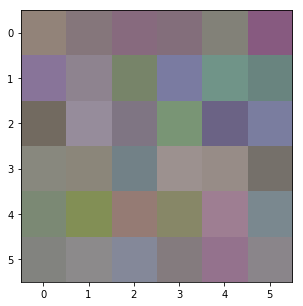

In [575]:
res1 = method1(image, mask)
plot_image(res1)

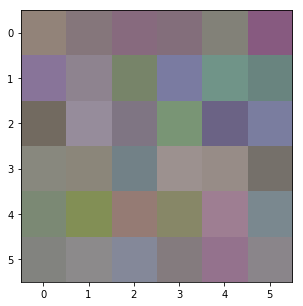

In [576]:
res2 = method2(image, mask)
plot_image(res2)

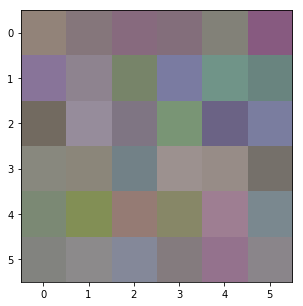

In [577]:
res3 = method3(image, mask)
plot_image(res3)

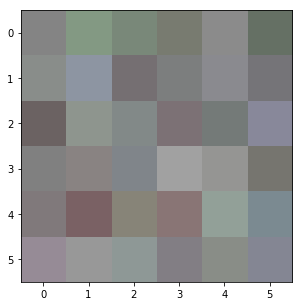

In [579]:
res4 = method4(image, mask)
plot_image(res4)

# Benchmarking

## 100 x 100 = 0.01 Mpixels

In [489]:
image = np.random.randint(low=0, high=255, size=(100, 100, 3))
mask = np.ones(shape=(3, 3))

%timeit method1(image, mask)
%timeit method2(image, mask)
%timeit method3(image, mask)

10.7 ms ± 254 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
331 ms ± 7.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.07 ms ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## 1000 x 1000 = 1 Mpixels

In [492]:
image = np.random.randint(low=0, high=255, size=(1000, 1000, 3))
mask = np.ones(shape=(3, 3))

%timeit method1(image, mask)
# %timeit method2(image, mask) --> crashes due to memory error
%timeit method3(image, mask)

1.12 s ± 20.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
118 ms ± 699 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 6000 x 6000 = 36 Mpixels

In [493]:
image = np.random.randint(low=0, high=255, size=(6000, 6000, 3))
mask = np.ones(shape=(3, 3))

%timeit method1(image, mask)
%timeit method3(image, mask)

40.9 s ± 1.69 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.58 s ± 574 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 1 Mega pixel image but different masks

In [507]:
image = np.random.randint(low=0, high=255, size=(1000, 1000, 3))
m10 = np.ones(shape=(10, 10))
m30 = np.ones(shape=(30, 30))

%timeit method3(image, m10)
%timeit method3(image, m30)

824 ms ± 95.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.07 s ± 242 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Test with a real image

In [494]:
test_im = plt.imread('image_test.jpg')
test_im.shape

(3008, 4008, 3)

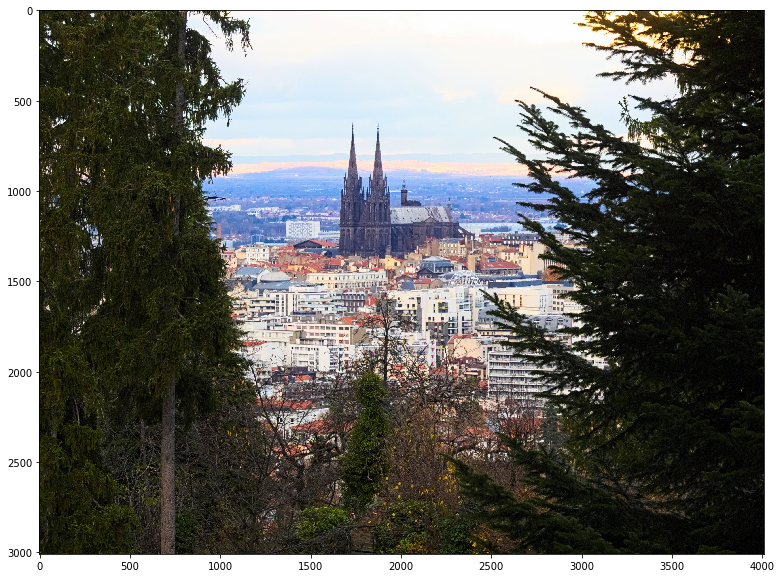

In [500]:
plot_image(test_im, h=10)

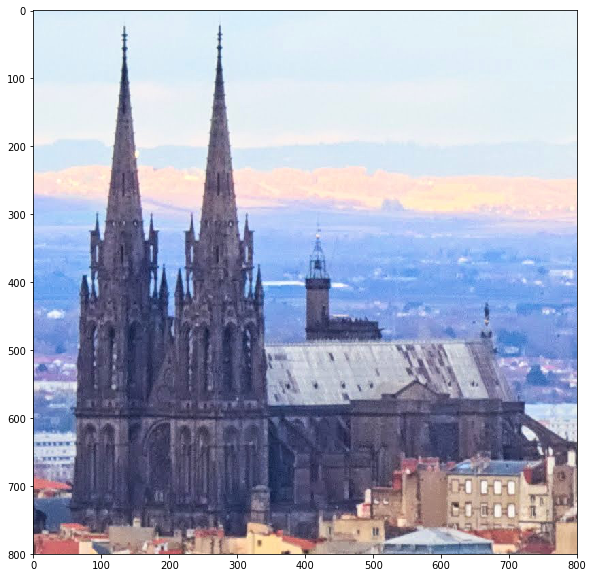

In [513]:
x1, x2, y1, y2 = 600, 1400, 1600, 2400
plot_image(test_im[x1:x2, y1:y2], h=10)

In [508]:
mask = np.ones(shape=(5, 5))
compressed_image = method3(test_im, mask)

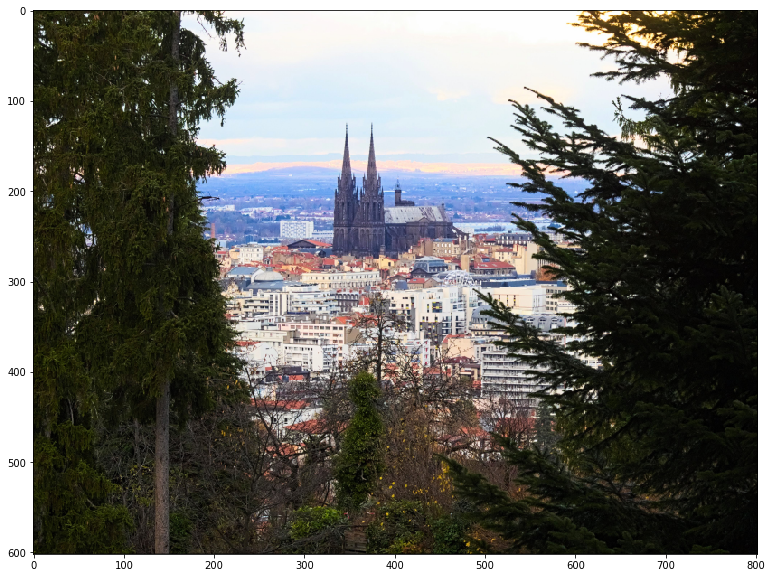

In [509]:
plot_image(compressed_image, h=10)

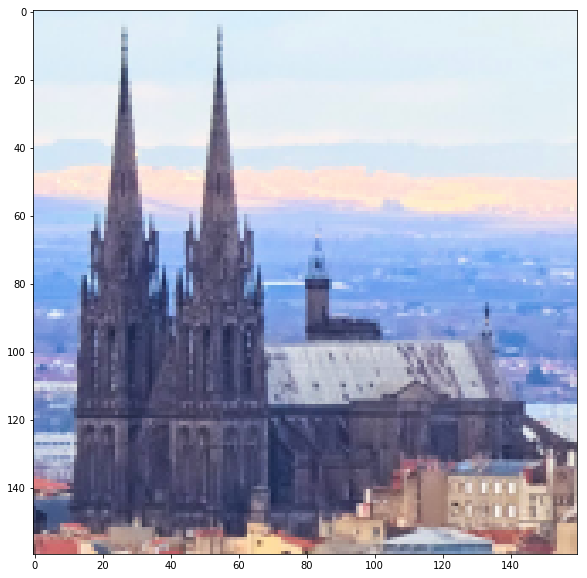

In [515]:
x1s = int(x1/5)
x2s = int(x2/5)
y1s = int(y1/5)
y2s = int(y2/5)
plot_image(compressed_image[x1s:x2s, y1s:y2s], h=10)